In [2]:
import xarray as xr
import pyrams.xarray
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from glob import glob
from tqdm import tqdm
import pint_xarray
ureg = pint_xarray.unit_registry

simlist = [
    '20',
    '200',
    '400',
    '600',
    '800',
    '1000',
    # '1200',    
    # '1400',
    # '1600',
    # '1800',
    # '2000'
]

simlist = ['salt' + l for l in simlist]

sims = {}
for sim in simlist:
#     flist = sorted(glob(f'/home/lsterzin/inp_project/idealized/full-suite-small/ccntest/output_inp1/{sim}/*.h5'))
#     data = xr.open_mfdataset(flist, combine='nested', concat_dim='time', parallel=True)
#     data = data.rams.fix_dims(flist, dx=62.5, dz=6.25, dt='hour')
    # data['time'].attrs = {'unit':'hour'}
    data = xr.open_dataset(f'netcdf/{sim}.nc')
    data = data.rams.apply_variable_metadata()
    # data['time'] = (data.time - data.time[0]) / np.timedelta64(1,'h')
    # if sim == 'control': sim='20'
    # sim = 'salt'+sim
    data.time.attrs['units'] = 'hour'
    sims[sim] = data

cmap = plt.get_cmap('jet', len(sims))

In [3]:
paper_dir = './paper_plots/'

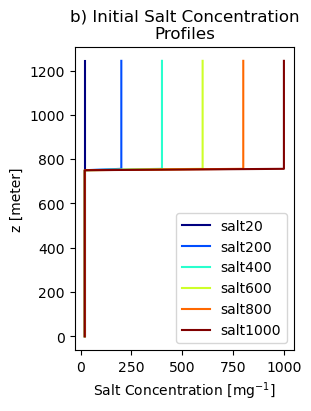

In [12]:
fig = plt.figure(figsize=(3,4), constrained_layout=True)
for i,(name, ds) in enumerate(sims.items()):
    ds.isel(time=0).SALT_FILM_NP.pint.to('1/mg').plot(y='z', label=name, color=cmap(i))
plt.legend()
plt.xlabel('Salt Concentration [mg$^{-1}$]')
plt.title('b) Initial Salt Concentration\nProfiles')
plt.savefig(f'{paper_dir}/01b.pdf')

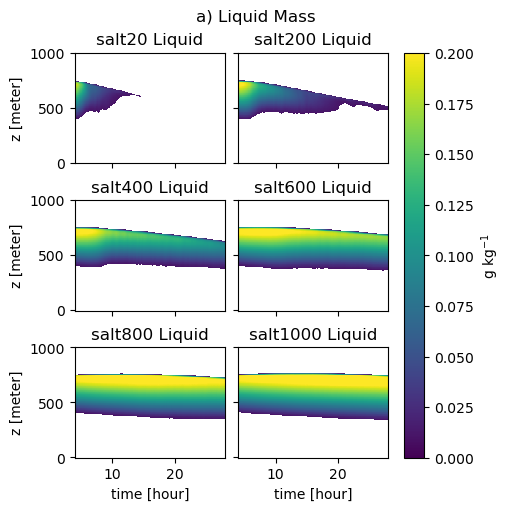

In [6]:
fig, axs = plt.subplots(3, 2, sharex=True, sharey=True, constrained_layout=True, figsize=(5,5))

for i,((name, ds), ax) in enumerate(zip(sims.items(), axs.flatten())):
    ds = ds.sel(time=slice(4,28))
    p = ds.RCP.where(ds.RCP >= 0.01 * ureg('g/kg')).pint.to('g/kg').plot(x='time', vmin=0, vmax=.2, ax=ax, add_colorbar=False)
    # c=(ds.RPP + ds.RSP + ds.RAP + ds.RGP + ds.RHP).pint.to('g/kg').plot.contour(x='time',ax=ax, colors='k')
    
    # ax.clabel(c, inline=True)
    
    ax.set_title(name + " Liquid")
    p.set_rasterized(True)
    if i%2 != 0: ax.set_ylabel('')
    if i not in [4,5]: ax.set_xlabel('')
       
plt.ylim(None,1000)
plt.colorbar(p, ax=axs.ravel().tolist(), shrink=1, label='g kg$^{-1}$')
# plt.legend()
# plt.xlabel('mg$^{-1}$')
plt.suptitle('a) Liquid Mass')
plt.savefig(f'{paper_dir}/02a.pdf')

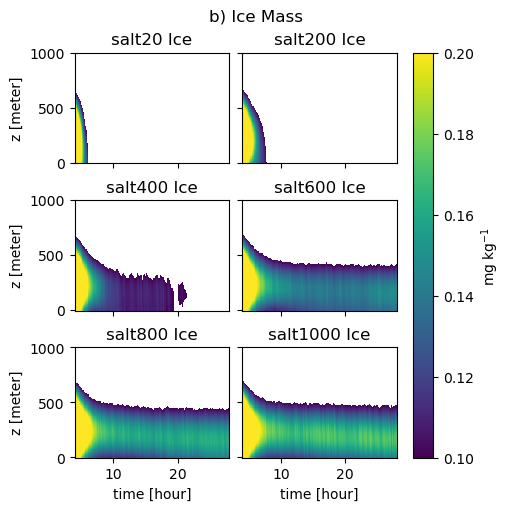

In [7]:
fig, axs = plt.subplots(3, 2, sharex=True, sharey=True, constrained_layout=True, figsize=(5,5))

for i,((name, ds), ax) in enumerate(zip(sims.items(), axs.flatten())):
    ds = ds.sel(time=slice(4,28))
    # p = ds.RCP.where(ds.RCP >= 0.01 * ureg('g/kg')).pint.to('g/kg').plot(x='time', vmin=0, vmax=.2, ax=ax, add_colorbar=False)
    ice=(ds.RPP + ds.RSP + ds.RAP + ds.RGP + ds.RHP).pint.to('mg/kg')

    c=ice.where(ice > 0.1*ureg('mg/kg')).plot(x='time',ax=ax, vmin=0.1, vmax=.2, add_colorbar=False)
    
    # ax.clabel(c, inline=True)
    
    ax.set_title(name + " Ice")
    c.set_rasterized(True)
    
    if i%2 != 0: ax.set_ylabel('')
    if i not in [4,5]: ax.set_xlabel('')
plt.ylim(None,1000)
plt.colorbar(c, ax=axs.ravel().tolist(), shrink=1, label='mg kg$^{-1}$')
# plt.legend()
# plt.xlabel('mg$^{-1}$')
# plt.title('Initial Salt Concentration Profiles')
plt.suptitle('b) Ice Mass')
plt.savefig(f'{paper_dir}/02b.pdf')

Warning, RDP not found in dataset - skipping in LWC calculation
Warning, RDP not found in dataset - skipping in LWC calculation
Warning, RDP not found in dataset - skipping in LWC calculation
Warning, RDP not found in dataset - skipping in LWC calculation
Warning, RDP not found in dataset - skipping in LWC calculation
Warning, RDP not found in dataset - skipping in LWC calculation


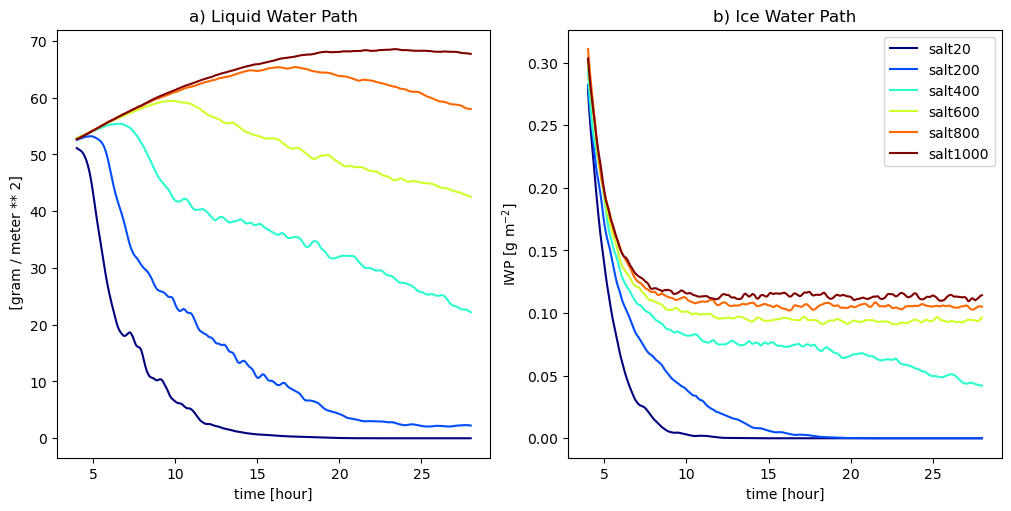

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), constrained_layout=True)
for i,(name, ds) in enumerate(sims.items()):
    ds = ds.sel(time=slice(4,28))
    (ds.rams.lwp * ureg('m')).pint.to('g/m^2').plot(ax=ax1,x='time', label=name, color=cmap(i))

# plt.legend()
ax.set_ylabel('LWP [g m$^{-2}$]')
ax1.set_title('a) Liquid Water Path')
# plt.savefig(f'{paper_dir}/lwp.pdf')    

for i,(name, ds) in enumerate(sims.items()):
    ds = ds.sel(time=slice(4,28))
    (ds.rams.iwp * ureg('m')).pint.to('g/m^2').plot(ax=ax2, x='time', label=name, color=cmap(i))

plt.legend()
ax2.set_ylabel('IWP [g m$^{-2}$]')
ax2.set_title('b) Ice Water Path')
plt.savefig(f'{paper_dir}/03.pdf')

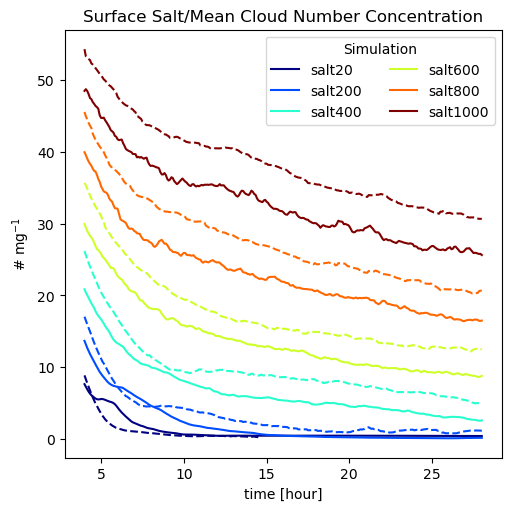

In [9]:
fig = plt.figure(figsize=(5,5), constrained_layout=True)
for i,name in enumerate(sims.keys()):
    ds = sims[name].sel(time=slice(4,28))
    bl_mass = (ds.SALT_FILM_NP + ds.REGEN_AERO1_NP).isel(z=0)
    acc = ds.ACCPAERO
    bl_mass.pint.to('1/mg').plot(color=cmap(i), label=name)
    ds.CCP.where(ds.RCP >= 0.01 *ureg('g/kg')).mean('z').pint.to('1/mg').plot(color=cmap(i), linestyle='--')
    # bl_mass.diff('time').plot(color=cmap(i), label=name) 
    # bl_rate = bl_mass.differentiate('time')
    # acc_rate = acc.differentiate('time')
    # acc_rate.plot(color=cmap(i), label=name)
    # (bl_rate + acc_rate).plot(color=cmap(i), label=name)
    
plt.legend(ncol=2, title='Simulation')
plt.ylabel('# mg$^{-1}$')
plt.xlabel('time [hour]')
plt.title('Surface Salt/Mean Cloud Number Concentration')
plt.savefig(f'{paper_dir}/04.pdf')

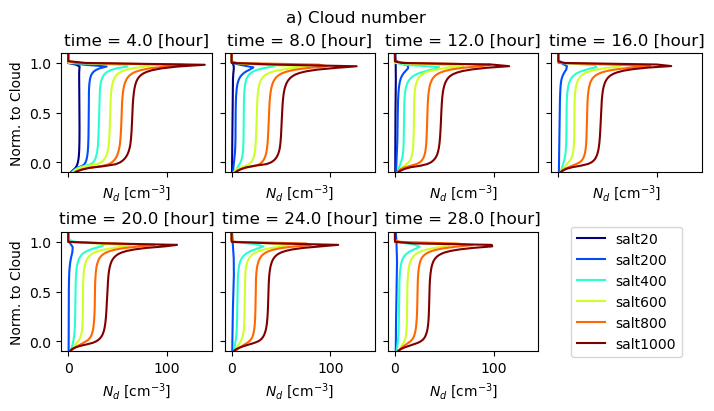

In [13]:
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True, constrained_layout=True, figsize=(7,4))
axs = axs.flatten()

times = [4, 8, 12, 16, 20, 24, 28]

for t,ax in zip(times, axs):
    handles = []
    for i,(name, ds) in enumerate(sims.items()):
        ds1 = ds.sel(time=t)
        p = (ds1.CCP * ds1.DN0).pint.to('1/cm^3').plot(y='Z_NORM_CLOUD', ax=ax, color=cmap(i), label=name)
        ax.set_ylim(-0.1,1.1)
        handles = handles + p
        ax.set_xlabel('$N_d$ [cm$^{-3}$]')
    if t in [4,20]: ax.set_ylabel('Norm. to Cloud')
    else: ax.set_ylabel('')

    # ax.set_xlabel(ds1.CCP.pint.to('1/mg').pint.units)

fax = axs[-1]
labs = [l.get_label() for l in handles]
fax.legend(handles, labs, loc='center')
fax.set_axis_off()
plt.suptitle('a) Cloud number')
plt.savefig(f'{paper_dir}/5a.pdf')


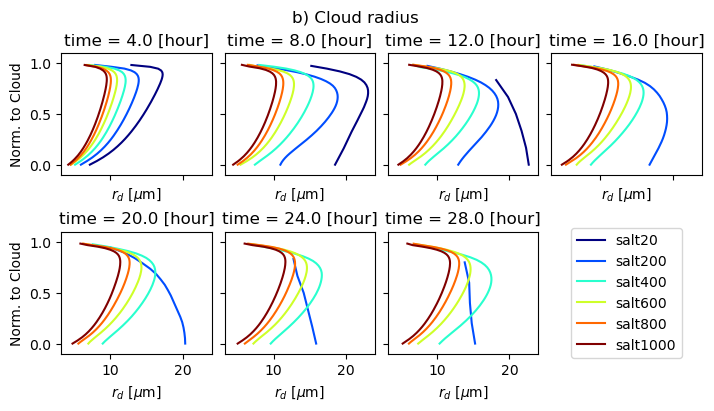

In [14]:
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True, constrained_layout=True, figsize=(7,4))
axs = axs.flatten()

times = [4, 8, 12, 16, 20, 24, 28]

for t,ax in zip(times, axs):
    handles = []
    for i,(name, ds) in enumerate(sims.items()):
        ds1 = ds.sel(time=t)
        v = ds1.rams.cloudradius
        l = v.where(ds1.RCP >= 0.01 * ureg('g/kg')).pint.to('micron').plot(y='Z_NORM_CLOUD', ax=ax, color=cmap(i), label=name)
        ax.set_ylim(-0.1,1.1)
        # handles.append(p[0].get_label())
        handles = handles + l
        ax.set_xlabel('$r_d$ [$\mu$m]')
        ax.set_title(f'time = {t}.0 [hour]')
    if t in [4,20]: ax.set_ylabel('Norm. to Cloud')
    else: ax.set_ylabel('')

            
    # ax.legend()

fax = axs[-1]
labs = [l.get_label() for l in handles]
fax.legend(handles, labs, loc='center')
fax.set_axis_off()
plt.suptitle('b) Cloud radius')
plt.savefig(f'{paper_dir}/05b.pdf')


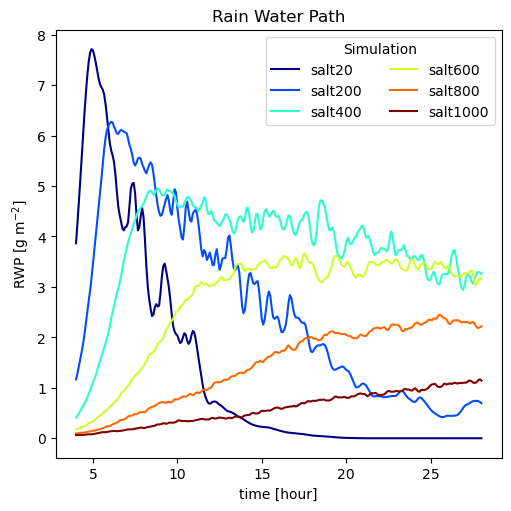

In [15]:
fig = plt.figure(figsize=(5,5), constrained_layout=True)
for i,name in enumerate(sims.keys()):
    ds = sims[name]
    ((ds.RRP * ds.DN0).integrate('z') * ureg('m')).sel(time=slice(4,28)).pint.to('g/m^2').plot(label=name, color=cmap(i))
plt.legend(ncol=2, title='Simulation')
plt.title('Rain Water Path')
plt.ylabel('RWP [g m$^{-2}$]')
plt.savefig(f'{paper_dir}/06.pdf')

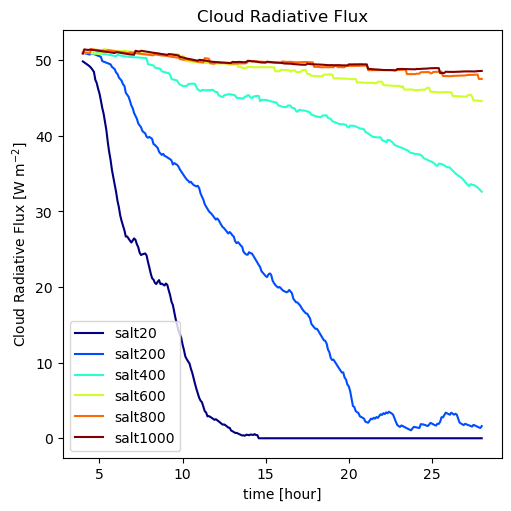

In [19]:
fig = plt.figure(figsize=(5,5), constrained_layout=True)
cp = 1004 * ureg('J/kg/K')
for i, (name,ds) in enumerate(sims.items()):
    ds = ds.sel(time=slice(4,28))
    # ds = ds.where(ds.Z_NORM_CLOUD <=1, drop=True)
    # ds = ds.where(ds.Z_NORM_CLOUD >=0, drop=True)
    v = -1* (ds.FTHRD * cp * ds.DN0).where(ds.Z_NORM_CLOUD <= 1,0).where(ds.Z_NORM_CLOUD >= 0,0).integrate('z') * ureg('m')
    v.pint.to('W/m^2').plot(label=name, color=cmap(i))
plt.ylabel('Cloud Radiative Flux [W m$^{-2}$]')
plt.legend()
plt.title('Cloud Radiative Flux')
plt.savefig(f'{paper_dir}/07.pdf')

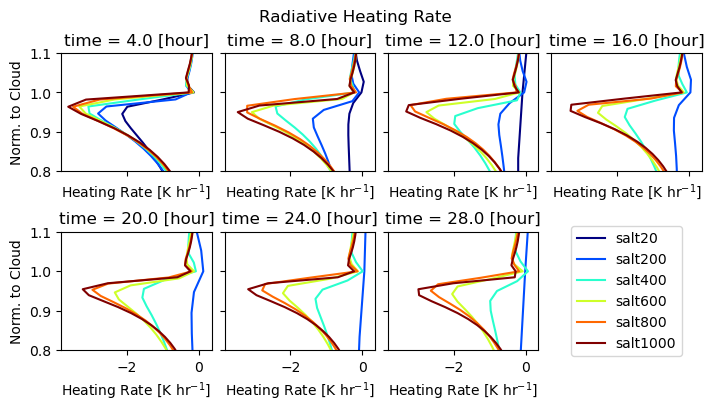

In [20]:
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True, constrained_layout=True, figsize=(7,4))
axs = axs.flatten()

times = [4, 8, 12, 16, 20, 24, 28]

for t,ax in zip(times, axs):
    handles = []
    for i,(name, ds) in enumerate(sims.items()):
        ds1 = ds.sel(time=t)
        l = (ds1.FTHRD).pint.to('K/hr').plot(y='Z_NORM_CLOUD', ax=ax, color=cmap(i), label=name)
        ax.set_ylim(.8,1.1)
        # handles.append(p[0].get_label())
        handles = handles + l
        ax.set_xlabel('Heating Rate [K hr$^{-1}$]')
    if t in [4,20]: ax.set_ylabel('Norm. to Cloud')
    else: ax.set_ylabel('')

    # ax.legend()

fax = axs[-1]
labs = [l.get_label() for l in handles]
fax.legend(handles, labs, loc='center')
fax.set_axis_off()
plt.suptitle('Radiative Heating Rate')
plt.savefig(f'{paper_dir}/08.pdf')


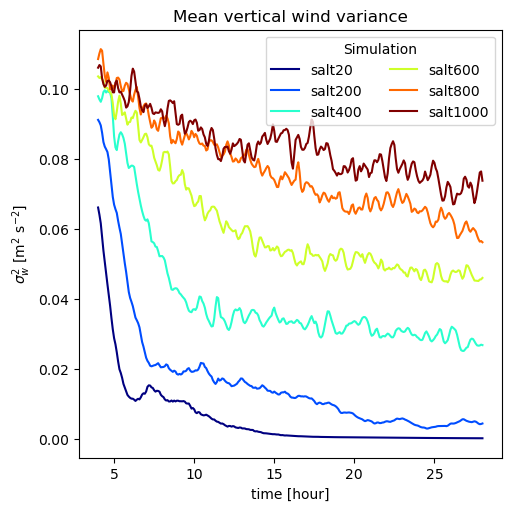

In [21]:
fig = plt.figure(figsize=(5,5), constrained_layout=True)
for i,name in enumerate(sims.keys()):
    ds = sims[name]
    (ds.VFLXW).sel(time=slice(4,28)).mean('z').plot(label=name, color=cmap(i))
plt.legend(ncol=2, title='Simulation')
plt.ylabel('$\sigma_w^2$ [m$^2$ s$^{-2}$]')
plt.title('Mean vertical wind variance')
plt.savefig(f'{paper_dir}/09a.pdf')

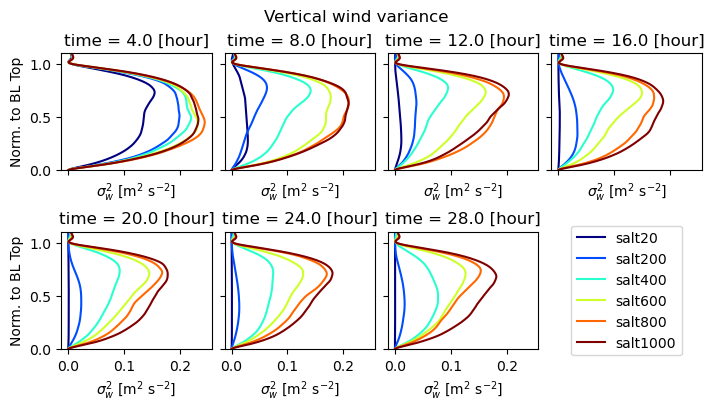

In [22]:
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True, constrained_layout=True, figsize=(7,4))
axs = axs.flatten()

times = [4, 8, 12, 16, 20, 24, 28]

for t,ax in zip(times, axs):
    handles = []
    for i,(name, ds) in enumerate(sims.items()):
        ds1 = ds.sel(time=t)
        l = (ds1.VFLXW).plot(y='Z_NORM_BLTOP', ax=ax, color=cmap(i), label=name)
        ax.set_ylim(.0,1.1)
        # handles.append(p[0].get_label())
        handles = handles + l
        ax.set_xlabel('$\sigma_w^2$ [m$^2$ s$^{-2}$]')
    # ax.legend()
    if t in [4,20]: ax.set_ylabel('Norm. to BL Top')
    else: ax.set_ylabel('')

fax = axs[-1]
labs = [l.get_label() for l in handles]
fax.legend(handles, labs, loc='center')
fax.set_axis_off()
plt.suptitle('Vertical wind variance')
plt.savefig(f'{paper_dir}/09b.pdf')


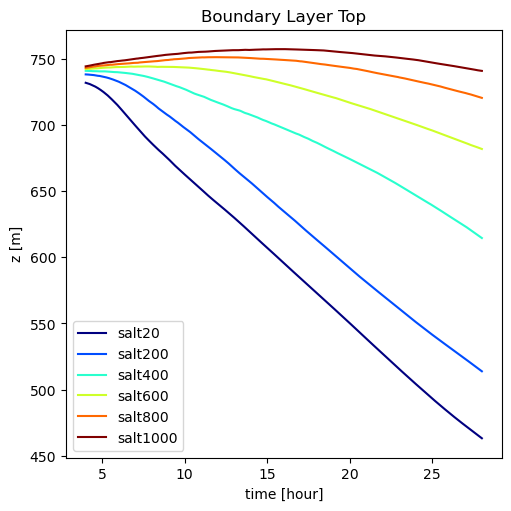

In [24]:
fig = plt.figure(figsize=(5,5), constrained_layout=True)
for i,(name, ds) in enumerate(sims.items()):
    ds = ds.sel(time=slice(4,28))
    ds.BLTOP.plot(x='time', label=name, color=cmap(i))

plt.legend()
plt.ylabel('z [m]')
plt.title('Boundary Layer Top')
plt.savefig(f'{paper_dir}/10a.pdf')

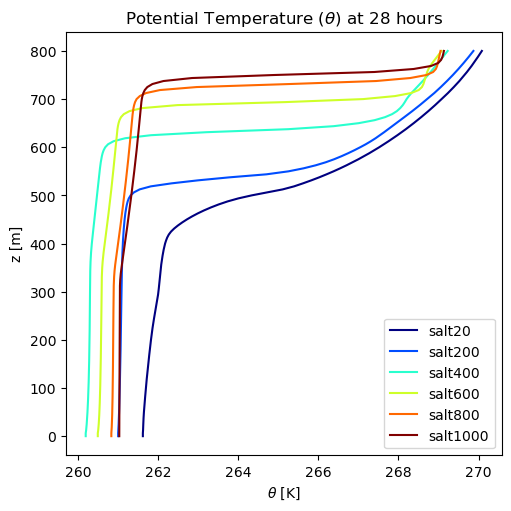

In [29]:
fig = plt.figure(figsize=(5,5), constrained_layout=True)

for i,(name, ds) in enumerate(sims.items()):
    ds = ds.sel(time=28, z=slice(0,800))
    ds.THETA.plot(y='z', label=name, color=cmap(i))
    
plt.legend()
plt.xlabel('$\\theta$ [K]')
plt.ylabel('z [m]')
plt.title('Potential Temperature ($\\theta$) at 28 hours')
plt.savefig(f'{paper_dir}/10b.pdf')

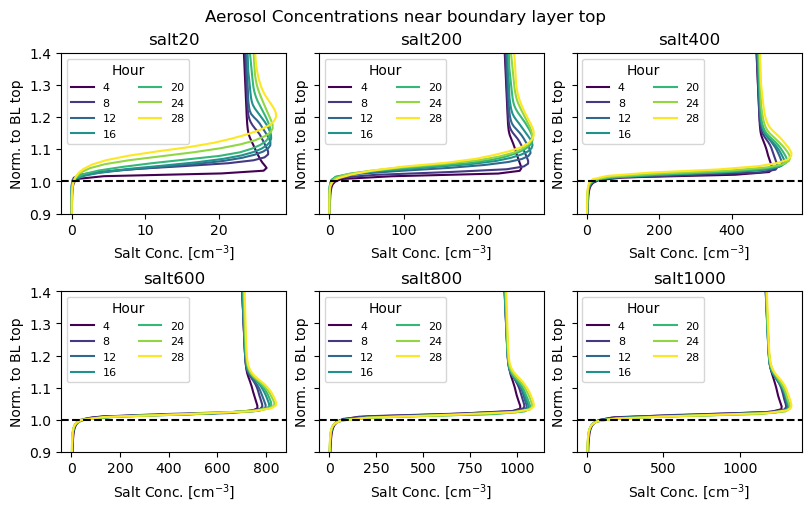

In [23]:
fig, axs = plt.subplots(2,3, sharex=False, sharey=True, constrained_layout=True, figsize=(8,5))

times = [4, 8, 12, 16, 20, 24, 28]
colors = plt.get_cmap('viridis', len(times))

for ((name,ds), ax) in zip(sims.items(), axs.flatten()):
    for i,t in enumerate(times):
        # print(i,t)
        ds1 = ds.sel(time=t)
        aero = (ds1.REGEN_AERO1_NP + ds1.SALT_FILM_NP) * ds1.DN0
        ax.set_ylim(0.9, 1.4)
        aero.pint.to('1/cm^3').plot(y='Z_NORM_BLTOP', ax=ax, color=colors(i), label=t)
    ax.legend(ncol=2, title='Hour', fontsize=8)
    ax.axhline(1, color='k', linestyle='--')
    ax.set_title(name)
    
    ax.set_ylabel('Norm. to BL top')
    ax.set_xlabel('Salt Conc. [cm$^{-3}$]')

plt.suptitle('Aerosol Concentrations near boundary layer top')
plt.savefig(f'{paper_dir}/10c.pdf')